In [1]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime

In [2]:
# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
df = pd.read_csv("merged_macro_commodity.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 7 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   date                                           408 non-null    object 
 1   Revenue, excluding grants (% of GDP)           408 non-null    float64
 2   GDP (constant 2015 US$)                        408 non-null    float64
 3   Employment to population ratio (15+, total %)  408 non-null    float64
 4   Crude Oil Brent Price                          408 non-null    float64
 5   Cocoa Price                                    408 non-null    float64
 6   Gold Price                                     408 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.4+ KB


In [4]:
data = df.copy()
data['date'] = pd.to_datetime(data['date'])

In [5]:
import plotly.express as px
import plotly.graph_objects as go


def plotting(title, data, x, y, x_label, y_label, text=False, lam=None):
    """General function to plot the data."""
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title, width=650, title_x=0.5, height=400)
    if text:
      fig.add_annotation(
          x='1952-12-20', y=10, text=f'Lambda = {lam:.3f}',
          align='left', yanchor='bottom', showarrow=False,
          font=dict(size=20, color="black", family="Courier New, monospace"),
          bordercolor='black', borderwidth=2, bgcolor="white"
      )
    fig.show()


def add_separator(width=650):
    """Add a horizontal line as a separator."""
    fig = go.Figure()
    fig.add_hline(y=0.5, line_dash="dot", line_color="gray", line_width=2)
    fig.update_layout(height=50, width=width, margin=dict(l=20, r=20, t=20, b=20), xaxis_visible=False, yaxis_visible=False)
    fig.show()


In [6]:
plotting(title='Revenue Over Time', data=data, x='date', y='Revenue, excluding grants (% of GDP)', x_label='Date', y_label='%')

In [7]:
len(data)

408

In [47]:
# Load your data
df = pd.read_csv('merged_macro_commodity.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# Feature and target columns
feature_cols = ['Revenue, excluding grants (% of GDP)', 'GDP (constant 2015 US$)', 'Employment to population ratio (15+, total %)']
target_cols = ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']

# Normalize
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[target_cols])

# Parameters
input_window = 12      # input sequence length
forecast_horizon = 6   # output sequence length

# Build sequences manually for Seq2Seq
X_seq, y_seq = [], []
for i in range(len(X_scaled) - input_window - forecast_horizon + 1):
    X_seq.append(X_scaled[i:i+input_window])
    y_seq.append(y_scaled[i+input_window:i+input_window+forecast_horizon])

X_seq = np.array(X_seq)  # (num_samples, 12, num_features)
y_seq = np.array(y_seq)  # (num_samples, 6, num_targets)

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Attention, Dropout, TimeDistributed

# Input dimensions
n_features = X_seq.shape[2]
n_targets = y_seq.shape[2]

UNITS = 256

# Encoder
encoder_inputs = Input(shape=(input_window, n_features), name='encoder_input')
encoder = LSTM(UNITS, return_state=True, return_sequences=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder with Teacher Forcing
decoder_inputs = Input(shape=(forecast_horizon, n_targets), name='decoder_input')
decoder_lstm = LSTM(UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Attention layer
attention = Attention(name='attention_layer')
context_vector = attention([decoder_outputs, encoder_outputs])

# Combine attention context vector with decoder output
decoder_combined_context = Concatenate(axis=-1, name='concat_context')([context_vector, decoder_outputs])
decoder_combined_context = Dropout(0.2)(decoder_combined_context)

# Output
outputs = TimeDistributed(Dense(n_targets, activation='linear'), name='output_layer')(decoder_combined_context)

# Define the full model for training (with teacher forcing)
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 12, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 6, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 12, 256), │    266,240 │ encoder_input[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 6, 256),  │    266,240 │ decoder_input[0]… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 6, 256)    │          0 │ decoder_lstm[0][… │
│ (Attention)         │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_context      │ (None, 6, 512)    │          0 │ attention_layer[… │
│ (Concatenate)       │                   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 6, 512)    │          0 │ concat_context[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6, 3)      │      1,539 │ dropout_12[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 534,019 (2.04 MB)

 Trainable params: 534,019 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Prepare decoder inputs for teacher forcing
# Shift y_seq by 1 and pad with zeros at the beginning
decoder_input_data = np.zeros((len(y_seq), forecast_horizon, n_targets))
for i in range(len(y_seq)):
    # Use the first value of targets as the first decoder input
    decoder_input_data[i, 0] = y_seq[i, 0]  
    # For the rest, use the previous target as input (shifted by 1)
    if forecast_horizon > 1:
        decoder_input_data[i, 1:] = y_seq[i, :-1]

# Training with teacher forcing
history = model.fit(
    [X_seq, decoder_input_data], y_seq,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

Epoch 1/50


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0582 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0155 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0093 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0086 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0075 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0051 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0043 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 10/50
10/10 ━━━━━━━━━━━━

In [50]:
# For inference (without teacher forcing)
encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(UNITS,))
decoder_state_input_c = Input(shape=(UNITS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input(shape=(1, n_targets))  # Just one timestep

encoder_output_input = Input(shape=(input_window, UNITS))

# Decoder inference setup
decoder_outputs, state_h, state_c = decoder_lstm(decoder_input, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Apply attention
context_vector = attention([decoder_outputs, encoder_output_input])
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])
decoder_combined_context = Dropout(0.2)(decoder_combined_context)

output = TimeDistributed(Dense(n_targets, activation='linear'))(decoder_combined_context)

decoder_model = Model(
    [decoder_input, encoder_output_input, decoder_state_input_h, decoder_state_input_c],
    [output] + decoder_states
)

# Function to generate predictions for a given input sequence
def predict_sequence(input_seq):
    # Encode input sequence
    encoder_output, h, c = encoder_model.predict(input_seq)
    
    # Start with a zeros array as first decoder input
    target_seq = np.zeros((1, 1, n_targets))
    
    # Collect predictions
    y_pred = np.zeros((1, forecast_horizon, n_targets))
    
    # Generate each timestep
    for t in range(forecast_horizon):
        # Run one step of decoder
        output, h, c = decoder_model.predict([target_seq, encoder_output, h, c])
        
        # Store prediction
        y_pred[0, t] = output[0, 0]
        
        # Update target sequence for next timestep
        target_seq = np.zeros((1, 1, n_targets))
        target_seq[0, 0] = output[0, 0]
    
    return y_pred

In [51]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Split data into train and test sets (using the last 20% as test)
test_size = int(0.2 * len(X_seq))
train_size = len(X_seq) - test_size

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# For teacher forcing, we need decoder inputs
decoder_input_data_train = np.zeros((len(y_train), forecast_horizon, n_targets))
for i in range(len(y_train)):
    decoder_input_data_train[i, 0] = y_train[i, 0]
    if forecast_horizon > 1:
        decoder_input_data_train[i, 1:] = y_train[i, :-1]

# Train the model
history = model.fit(
    [X_train, decoder_input_data_train], y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)




Epoch 1/50


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028 - val_loss: 0.0063 - learning_rate: 2.5000e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0025 - val_loss: 0.0087 - learning_rate: 2.5000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021 - val_loss: 0.0106 - learning_rate: 2.5000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0110 - learning_rate: 2.5000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - val_loss: 0.0116 - learning_rate: 2.5000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022 - val_loss: 0.0118 - learning_rate: 2.5000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020 - val_loss: 0.0119 - learning_rate: 1.2500e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022 - val_loss: 0.0121 - learning_rate: 1.2500e-04
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 0.0118 - learning_rate: 1.2500e-04
Epoch 10/50


In [52]:
# Make predictions on test set
y_pred = []
for i in range(len(X_test)):
    input_seq = X_test[i:i+1]
    pred = predict_sequence(input_seq)
    y_pred.append(pred[0])

y_pred = np.array(y_pred)

# Inverse transform predictions and actual values to original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, n_targets)).reshape(y_test.shape)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, n_targets)).reshape(y_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

In [53]:
# Define commodity names for reporting
commodity_names = ['Crude Oil', 'Cocoa', 'Gold']

# Calculate metrics for each commodity and each forecast horizon
def calculate_mape(y_true, y_pred):
    """Calculate MAPE with handling for zero values"""
    mask = (y_true != 0)
    return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

# Dictionary to store all metrics
metrics = {'MAE': {}, 'RMSE': {}, 'MAPE': {}}

# Print overall metrics for each commodity
print("\n===== OVERALL METRICS =====")
for j, commodity in enumerate(commodity_names):
    # Calculate metrics across all horizons
    true_values = y_test_orig[:, :, j].flatten()
    pred_values = y_pred_orig[:, :, j].flatten()
    
    mae = mean_absolute_error(true_values, pred_values)
    rmse = np.sqrt(mean_squared_error(true_values, pred_values))
    mape = calculate_mape(true_values, pred_values)
    
    metrics['MAE'][commodity] = mae
    metrics['RMSE'][commodity] = rmse
    metrics['MAPE'][commodity] = mape
    
    print(f"\n{commodity} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

# Print metrics for each forecast horizon
print("\n===== METRICS BY FORECAST HORIZON =====")
for h in range(forecast_horizon):
    print(f"\nHorizon {h+1} (t+{h+1}):")
    for j, commodity in enumerate(commodity_names):
        true_values = y_test_orig[:, h, j]
        pred_values = y_pred_orig[:, h, j]
        
        mae = mean_absolute_error(true_values, pred_values)
        rmse = np.sqrt(mean_squared_error(true_values, pred_values))
        mape = calculate_mape(true_values, pred_values)
        
        if commodity not in metrics['MAE']:
            metrics['MAE'][commodity] = []
            metrics['RMSE'][commodity] = []
            metrics['MAPE'][commodity] = []
            
        metrics['MAE'].setdefault(f"{commodity}_horizon", []).append(mae)
        metrics['RMSE'].setdefault(f"{commodity}_horizon", []).append(rmse)
        metrics['MAPE'].setdefault(f"{commodity}_horizon", []).append(mape)
        
        print(f"  {commodity}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")



===== OVERALL METRICS =====

Crude Oil Metrics:
MAE: 77.45
RMSE: 79.94
MAPE: 106.13%

Cocoa Metrics:
MAE: 2.34
RMSE: 2.86
MAPE: 72.26%

Gold Metrics:
MAE: 1508.03
RMSE: 1543.05
MAPE: 85.24%

===== METRICS BY FORECAST HORIZON =====

Horizon 1 (t+1):
  Crude Oil: MAE=76.75, RMSE=79.30, MAPE=105.43%
  Cocoa: MAE=2.21, RMSE=2.64, MAPE=72.40%
  Gold: MAE=1486.46, RMSE=1515.97, MAPE=86.08%

Horizon 2 (t+2):
  Crude Oil: MAE=76.15, RMSE=78.70, MAPE=104.25%
  Cocoa: MAE=2.25, RMSE=2.71, MAPE=71.86%
  Gold: MAE=1491.81, RMSE=1523.11, MAPE=85.62%

Horizon 3 (t+3):
  Crude Oil: MAE=76.98, RMSE=79.48, MAPE=105.34%
  Cocoa: MAE=2.29, RMSE=2.77, MAPE=71.55%
  Gold: MAE=1496.25, RMSE=1529.80, MAPE=85.04%

Horizon 4 (t+4):
  Crude Oil: MAE=77.93, RMSE=80.39, MAPE=106.68%
  Cocoa: MAE=2.34, RMSE=2.85, MAPE=71.79%
  Gold: MAE=1507.30, RMSE=1543.65, MAPE=84.78%

Horizon 5 (t+5):
  Crude Oil: MAE=78.42, RMSE=80.86, MAPE=107.47%
  Cocoa: MAE=2.42, RMSE=2.97, MAPE=72.50%
  Gold: MAE=1523.37, RMSE=1561.75, 

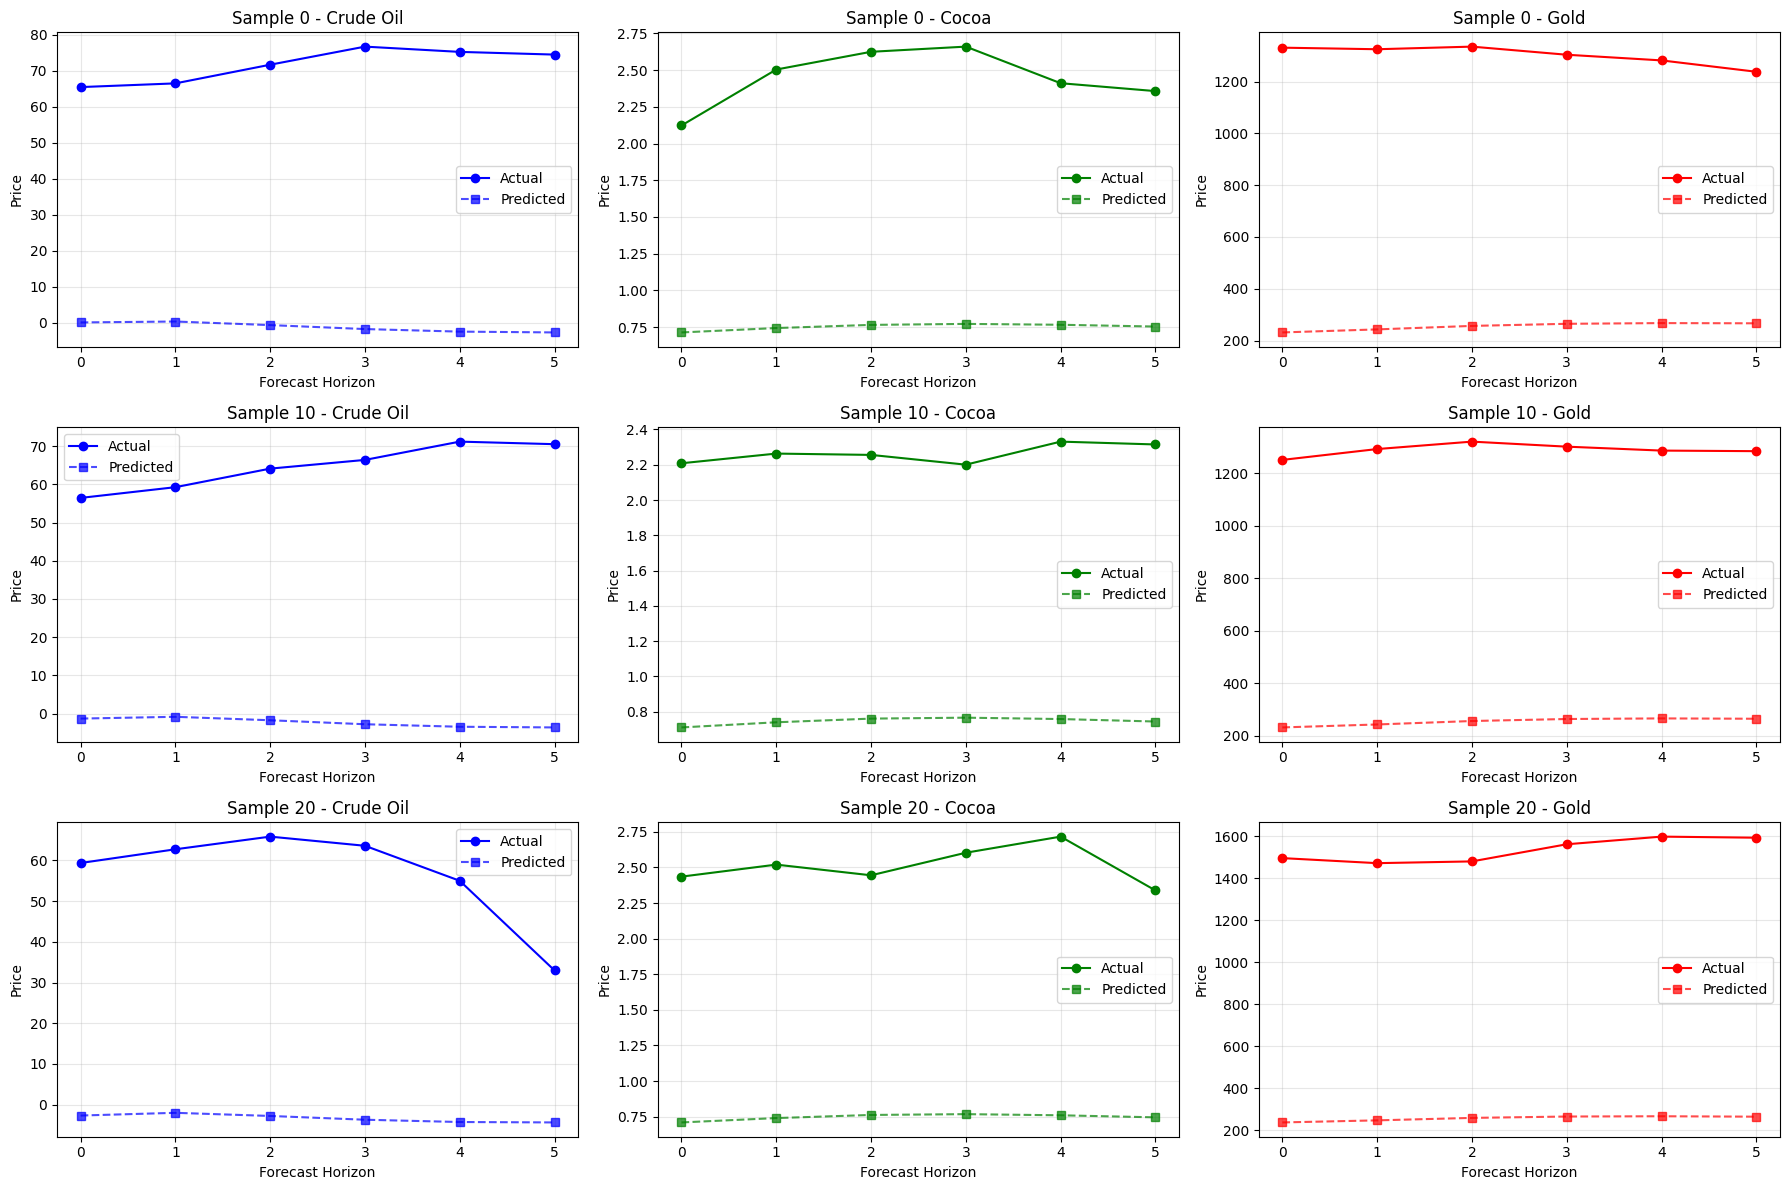

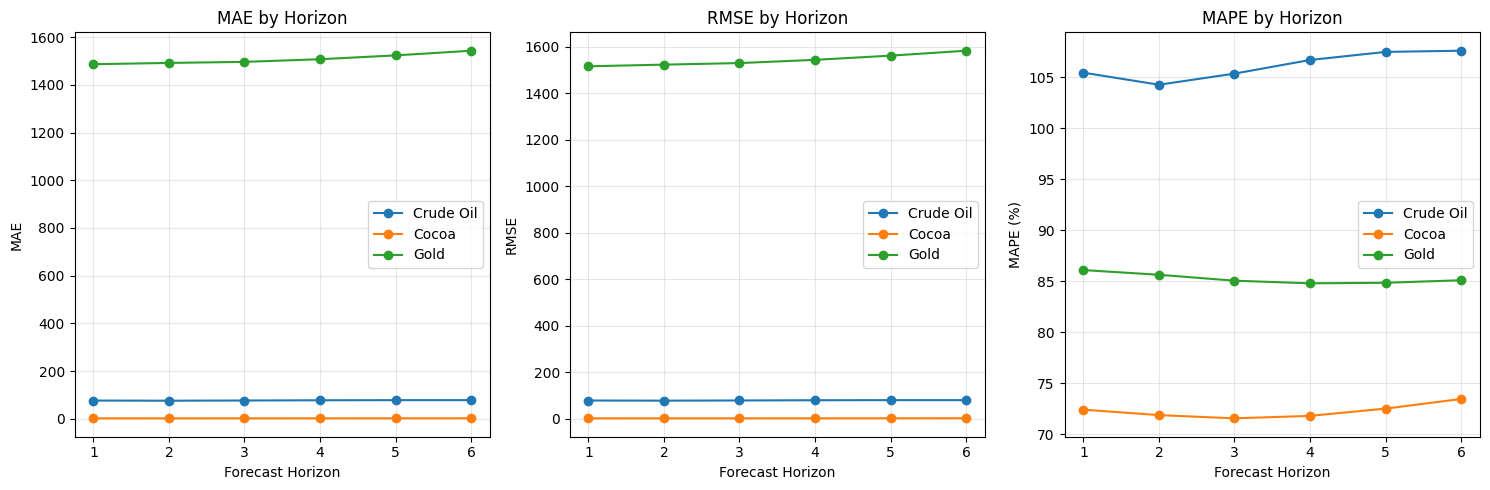

In [54]:
# Visualize the results
plt.figure(figsize=(18, 12))

# Plot forecasts for a few test samples
sample_indices = [0, 10, 20]  # Choose a few test samples to visualize
colors = ['blue', 'green', 'red']

for idx, i in enumerate(sample_indices):
    for j, commodity in enumerate(commodity_names):
        plt.subplot(len(sample_indices), len(commodity_names), idx*len(commodity_names) + j + 1)
        
        # Plot actual vs predicted
        plt.plot(range(forecast_horizon), y_test_orig[i, :, j], 'o-', color=colors[j], label='Actual')
        plt.plot(range(forecast_horizon), y_pred_orig[i, :, j], 's--', color=colors[j], alpha=0.7, label='Predicted')
        
        plt.title(f'Sample {i} - {commodity}')
        plt.xlabel('Forecast Horizon')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forecast_samples.png')
plt.show()

# Plot metrics by horizon
plt.figure(figsize=(15, 5))

# Plot MAE by horizon for each commodity
plt.subplot(1, 3, 1)
for j, commodity in enumerate(commodity_names):
    plt.plot(range(1, forecast_horizon+1), metrics['MAE'][f"{commodity}_horizon"], 'o-', label=commodity)
plt.title('MAE by Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot RMSE by horizon
plt.subplot(1, 3, 2)
for j, commodity in enumerate(commodity_names):
    plt.plot(range(1, forecast_horizon+1), metrics['RMSE'][f"{commodity}_horizon"], 'o-', label=commodity)
plt.title('RMSE by Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot MAPE by horizon
plt.subplot(1, 3, 3)
for j, commodity in enumerate(commodity_names):
    plt.plot(range(1, forecast_horizon+1), metrics['MAPE'][f"{commodity}_horizon"], 'o-', label=commodity)
plt.title('MAPE by Horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('MAPE (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_by_horizon.png')
plt.show()